# Notebook 03 - Pipeline final e predicoes

Treinar o modelo no dev completo, gerar predicoes pro teste, e salvar tudo.

Saida: `submissao_case.csv` com ID_CLIENTE, SAFRA_REF, PROBABILIDADE_INADIMPLENCIA.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import json
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb

from src.data_loader import load_all_data
from src.feature_engineering import (
    create_target, build_full_feature_matrix
)
from src.model_utils import evaluate_binary_proba
from src.config import (
    RANDOM_SEED, OUTPUT_DIR, FIGURES_DIR,
    CATEGORICAL_FEATURES, NUMERIC_FEATURES_BASE, HIST_WINDOWS
)

print('Setup completo.')

Setup completo.


## 1. Dados e configuracao

In [2]:
cadastral, info, pag_dev, pag_teste = load_all_data()

# Criar target no dev
pag_dev = create_target(pag_dev)
print(f'\nTaxa de default no dev: {pag_dev["TARGET"].mean():.4f}')

  Cadastral: 66 clientes PF descartados (foco em PJ)
  Dev: 219 transacoes PF descartadas
  Teste: 85 transacoes PF descartadas
  Info: 254 registros PF descartados
Cadastral:         1249 registros, 7 colunas
Info:             24147 registros, 4 colunas
Pagamentos Dev:   77195 registros, 7 colunas
Pagamentos Teste: 12190 registros, 6 colunas

Taxa de default no dev: 0.0698


In [3]:
# Carregar melhores parametros do Notebook 02 (se existir)
config_path = OUTPUT_DIR / 'best_model_config.json'
if config_path.exists():
    with open(config_path) as f:
        best_config = json.load(f)
    best_params = best_config['best_params']
    model_type = best_config.get('model_type', 'XGBoost')
    print(f'Modelo: {model_type}')
    print('Parametros carregados do Notebook 02:')
    for k, v in best_params.items():
        print(f'  {k}: {v}')
else:
    print('Config nao encontrada - usando parametros default XGBoost')
    n_pos_default = 0.07  # taxa de default aproximada
    best_params = {
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'max_depth': 6,
        'min_child_weight': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'gamma': 0,
        'scale_pos_weight': (1 - n_pos_default) / n_pos_default,
        'random_state': RANDOM_SEED,
        'eval_metric': 'logloss',
        'verbosity': 0,
        'n_jobs': -1,
    }


Modelo: XGBoost
Parametros carregados do Notebook 02:
  learning_rate: 0.016681827706241187
  max_depth: 5
  min_child_weight: 18
  subsample: 0.8005273613853869
  colsample_bytree: 0.5671761789634215
  reg_alpha: 2.1781043739084716
  reg_lambda: 0.8370536629719875
  gamma: 1.3742647449763135
  n_estimators: 1000
  scale_pos_weight: 12.989557876027549
  random_state: 42
  eval_metric: logloss
  verbosity: 0
  n_jobs: -1


## 2. Features para dev completo e teste

In [4]:
%%time
# Features para todo o dev (treino final)
print('Construindo features para dataset de DESENVOLVIMENTO (treino final)...')
df_dev_features = build_full_feature_matrix(
    transactions_df=pag_dev,
    history_df=pag_dev,
    cadastral=cadastral,
    info=info,
    verbose=True
)
print(f'\nDev features shape: {df_dev_features.shape}')

Construindo features para dataset de DESENVOLVIMENTO (treino final)...
1/5 Features transacionais...
2/5 Features de contexto da safra...


3/5 Features cadastrais...


4/5 Features de info mensal...
5/5 Features comportamentais (pode demorar)...


  5000/20940 pares processados...


  10000/20940 pares processados...


  15000/20940 pares processados...


  20000/20940 pares processados...


Matriz final: 77195 linhas x 65 colunas

Dev features shape: (77195, 65)
CPU times: user 28.7 s, sys: 241 ms, total: 28.9 s
Wall time: 29 s


In [5]:
%%time
# Features para teste - usando SOMENTE dev como historico
print('Construindo features para dataset de TESTE...')
df_test_features = build_full_feature_matrix(
    transactions_df=pag_teste,
    history_df=pag_dev,  # Historico vem SOMENTE do dev!
    cadastral=cadastral,
    info=info,
    verbose=True
)
print(f'\nTest features shape: {df_test_features.shape}')

Construindo features para dataset de TESTE...
1/5 Features transacionais...
2/5 Features de contexto da safra...
3/5 Features cadastrais...
4/5 Features de info mensal...
5/5 Features comportamentais (pode demorar)...


Matriz final: 12190 linhas x 62 colunas

Test features shape: (12190, 62)
CPU times: user 4.41 s, sys: 16.8 ms, total: 4.42 s
Wall time: 4.42 s


In [6]:
# Definir features
behavioral_cols = [c for c in df_dev_features.columns if c.startswith('HIST_') or c in ['TREND_DEFAULT', 'MESES_DESDE_ULTIMO_DEFAULT']]

numeric_features = NUMERIC_FEATURES_BASE + behavioral_cols + ['FLAG_COVID']
numeric_features = [c for c in numeric_features if c in df_dev_features.columns]
categorical_features = [c for c in CATEGORICAL_FEATURES if c in df_dev_features.columns]
all_features = numeric_features + categorical_features

print(f'Features: {len(all_features)} total ({len(numeric_features)} num + {len(categorical_features)} cat)')

# Verificar que todas existem no teste tambem
missing_in_test = [c for c in all_features if c not in df_test_features.columns]
if missing_in_test:
    print(f'ATENCAO: Features ausentes no teste: {missing_in_test}')
else:
    print('Todas as features presentes no teste.')

Features: 57 total (50 num + 7 cat)
Todas as features presentes no teste.


## 3. Pipeline sklearn

In [7]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), categorical_features)
    ],
    remainder='drop'
)

# Garantir parametros corretos para XGBoost
model_params = best_params.copy()
model_params['random_state'] = RANDOM_SEED
model_params['verbosity'] = 0
model_params['eval_metric'] = 'logloss'
model_params['n_jobs'] = -1
if 'n_estimators' not in model_params:
    model_params['n_estimators'] = 1000

# Calcular scale_pos_weight se nao presente
if 'scale_pos_weight' not in model_params:
    n_pos = y_dev.sum()
    n_neg = len(y_dev) - n_pos
    model_params['scale_pos_weight'] = n_neg / n_pos

# Remover parametros LightGBM se vieram do config
for lgb_param in ['is_unbalance', 'verbose', 'bagging_freq', 'feature_fraction', 
                   'bagging_fraction', 'num_leaves', 'min_child_samples']:
    model_params.pop(lgb_param, None)

# Pipeline completo com XGBoost
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(**model_params))
])

print('Pipeline criado (XGBoost):')
print(pipeline)


Pipeline criado (XGBoost):
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['VALOR_A_PAGAR', 'TAXA',
                                                   'LOG_VALOR_A_PAGAR',
                                                   'DIAS_ATE_VENCIMENTO',
                                                   'MES_REF', 'ANO_REF',
                                                   'TEMPO_CADASTRO_MESES',
                                                   'LOG_RENDA_MES_ANTERIOR',
                                                   'NO_FUNCIONARIOS',
                                                   'RENDA_MISSING',
                                                   'FUNC_MISSING',
                                                   'QTD_TRANSACOES_MES',
                                                   'SOMA_VALOR_MES',
     

## 4. Treino no dev completo

In [8]:
%%time
X_dev = df_dev_features[all_features]
y_dev = df_dev_features['TARGET']

print(f'Treinando no dataset COMPLETO: {len(X_dev):,} transacoes')
print(f'Taxa de default: {y_dev.mean():.4f}')

pipeline.fit(X_dev, y_dev)
print('\nTreinamento concluido!')

# Metricas in-sample (referencia, nao para avaliacao)
y_prob_insample = pipeline.predict_proba(X_dev)[:, 1]
print('\nMetricas in-sample (referencia):')
_ = evaluate_binary_proba(y_dev, y_prob_insample)

Treinando no dataset COMPLETO: 77,195 transacoes
Taxa de default: 0.0698



Treinamento concluido!



Metricas in-sample (referencia):
  AUC-ROC        : 0.9825
  Gini           : 0.9649
  KS             : 0.8827
  Brier Score    : 0.0546
  PR-AUC         : 0.8220
  Log Loss       : 0.1883
CPU times: user 11.1 s, sys: 1.49 s, total: 12.6 s
Wall time: 3.93 s


## 5. Predicoes no teste

In [9]:
# Gerar predicoes
X_test = df_test_features[all_features]
print(f'Gerando predicoes para {len(X_test):,} transacoes de teste...')

probabilidades = pipeline.predict_proba(X_test)[:, 1]
print(f'\nEstatisticas das predicoes:')
print(f'  Min:    {probabilidades.min():.6f}')
print(f'  Max:    {probabilidades.max():.6f}')
print(f'  Media:  {probabilidades.mean():.6f}')
print(f'  Mediana:{np.median(probabilidades):.6f}')
print(f'  Std:    {probabilidades.std():.6f}')
print(f'  NaN:    {np.isnan(probabilidades).sum()}')

Gerando predicoes para 12,190 transacoes de teste...

Estatisticas das predicoes:
  Min:    0.000892
  Max:    0.993842
  Media:  0.118794
  Mediana:0.029508
  Std:    0.209135
  NaN:    0


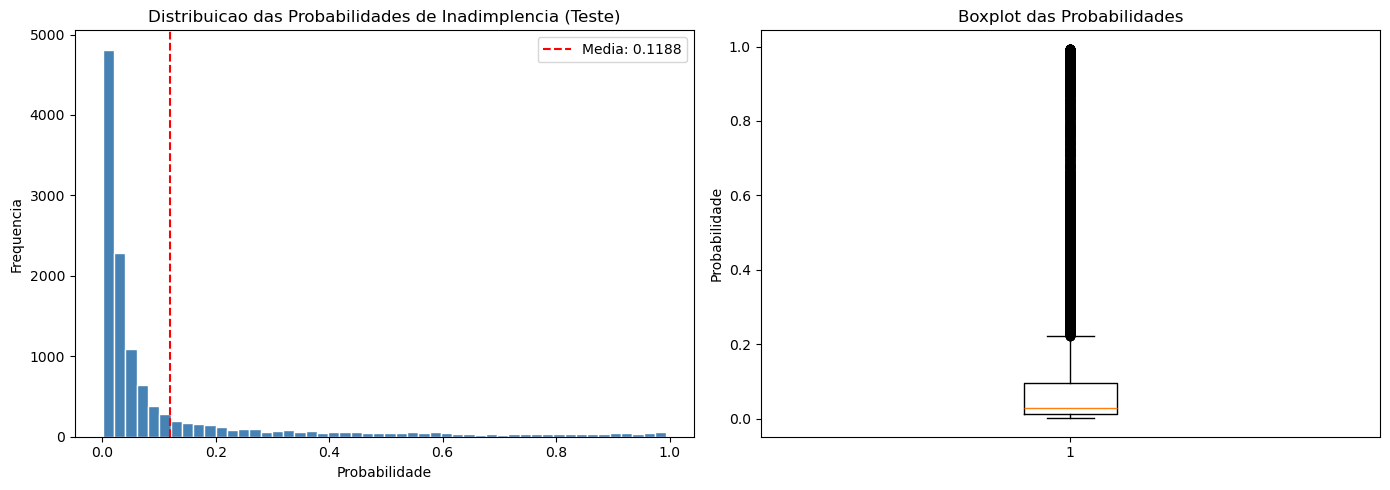

In [10]:
# Como ficaram as predicoes
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(probabilidades, bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Distribuicao das Probabilidades de Inadimplencia (Teste)')
axes[0].set_xlabel('Probabilidade')
axes[0].set_ylabel('Frequencia')
axes[0].axvline(probabilidades.mean(), color='red', linestyle='--',
                label=f'Media: {probabilidades.mean():.4f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(probabilidades, vert=True)
axes[1].set_title('Boxplot das Probabilidades')
axes[1].set_ylabel('Probabilidade')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'predicoes_teste_dist.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Arquivo de submissao

In [11]:
# Criar DataFrame de submissao
submissao = pd.DataFrame({
    'ID_CLIENTE': df_test_features['ID_CLIENTE'].values,
    'SAFRA_REF': df_test_features['SAFRA_REF'].dt.strftime('%Y-%m-%d').values,
    'PROBABILIDADE_INADIMPLENCIA': probabilidades
})

# Validacoes
print('=== VALIDACOES DO ARQUIVO DE SUBMISSAO ===')
print(f'Numero de linhas: {len(submissao):,} (esperado: {len(pag_teste):,})')
print(f'Colunas: {list(submissao.columns)}')
print(f'Nulos por coluna:\n{submissao.isna().sum()}')
print(f'Probabilidades em [0,1]: min={submissao["PROBABILIDADE_INADIMPLENCIA"].min():.6f}, max={submissao["PROBABILIDADE_INADIMPLENCIA"].max():.6f}')
n_expected = len(pag_teste)
assert len(submissao) == n_expected, f'Esperado {n_expected} linhas, obteve {len(submissao)}'
assert submissao['PROBABILIDADE_INADIMPLENCIA'].between(0, 1).all(), 'Probabilidades fora de [0,1]!'
assert submissao.isna().sum().sum() == 0, 'Existem nulos no arquivo!'
print('\nTodas as validacoes passaram!')

=== VALIDACOES DO ARQUIVO DE SUBMISSAO ===
Numero de linhas: 12,190 (esperado: 12,190)
Colunas: ['ID_CLIENTE', 'SAFRA_REF', 'PROBABILIDADE_INADIMPLENCIA']
Nulos por coluna:
ID_CLIENTE                     0
SAFRA_REF                      0
PROBABILIDADE_INADIMPLENCIA    0
dtype: int64
Probabilidades em [0,1]: min=0.000892, max=0.993842

Todas as validacoes passaram!


In [12]:
# Salvar
submissao_path = OUTPUT_DIR / 'submissao_case.csv'
submissao.to_csv(submissao_path, index=False)
print(f'Arquivo salvo em: {submissao_path}')
print(f'\nPrimeiras 10 linhas:')
submissao.head(10)

Arquivo salvo em: /Users/ygorhenriquetaramellivitor/Documents/Projetos/Projeto data risck sem resolver/datarisk-case-ds-junior-master/outputs/submissao_case.csv

Primeiras 10 linhas:


,ID_CLIENTE,SAFRA_REF,PROBABILIDADE_INADIMPLENCIA
0,5058298901476893676,2021-07-01,0.062827
1,274692171162531764,2021-07-01,0.053211
2,274692171162531764,2021-07-01,0.103835
3,274692171162531764,2021-07-01,0.053859
4,465309249432033993,2021-07-01,0.033150
5,465309249432033993,2021-07-01,0.026729
6,465309249432033993,2021-07-01,0.019312
7,465309249432033993,2021-07-01,0.019955
8,5883155883105348987,2021-07-01,0.191551
9,5883155883105348987,2021-07-01,0.080368


In [13]:
# Estatisticas descritivas
print('Estatisticas descritivas das predicoes:')
print(submissao['PROBABILIDADE_INADIMPLENCIA'].describe())

# Percentis
print('\nPercentis:')
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    val = np.percentile(probabilidades, p)
    print(f'  P{p:>2}: {val:.6f}')

Estatisticas descritivas das predicoes:
count    12190.000000
mean         0.118794
std          0.209144
min          0.000892
25%          0.013079
50%          0.029508
75%          0.096512
max          0.993842
Name: PROBABILIDADE_INADIMPLENCIA, dtype: float64

Percentis:
  P 1: 0.002181
  P 5: 0.004326
  P10: 0.006370
  P25: 0.013079
  P50: 0.029508
  P75: 0.096512
  P90: 0.402769
  P95: 0.651096
  P99: 0.944850


## 7. Salvando o modelo

In [14]:
# Salvar pipeline completo
model_path = OUTPUT_DIR / 'modelo_final.joblib'
joblib.dump(pipeline, model_path)
print(f'Modelo salvo em: {model_path}')

# Verificar que carrega corretamente
pipeline_loaded = joblib.load(model_path)
probs_check = pipeline_loaded.predict_proba(X_test)[:, 1]
assert np.allclose(probs_check, probabilidades), 'Predicoes divergem apos re-carga!'
print('Verificacao de integridade: OK')

Modelo salvo em: /Users/ygorhenriquetaramellivitor/Documents/Projetos/Projeto data risck sem resolver/datarisk-case-ds-junior-master/outputs/modelo_final.joblib
Verificacao de integridade: OK


## 8. Funcao de scoring para producao

In [15]:
def score_new_transactions(new_transactions_df, history_df, cadastral_df, info_df,
                           model_path=None, pipeline=None):
    """Funcao de scoring para novas transacoes em producao.

    Args:
        new_transactions_df: DataFrame com novas transacoes (mesma estrutura de base_pagamentos_teste)
        history_df: DataFrame com historico de pagamentos (com TARGET e DIAS_ATRASO)
        cadastral_df: Base cadastral
        info_df: Base info mensal
        model_path: Caminho para o modelo serializado (ou None se pipeline fornecido)
        pipeline: Pipeline ja carregado (ou None para carregar de model_path)

    Returns:
        DataFrame com ID_CLIENTE, SAFRA_REF, PROBABILIDADE_INADIMPLENCIA
    """
    if pipeline is None:
        if model_path is None:
            raise ValueError('Fornecer model_path ou pipeline')
        pipeline = joblib.load(model_path)

    # Construir features
    features_df = build_full_feature_matrix(
        transactions_df=new_transactions_df,
        history_df=history_df,
        cadastral=cadastral_df,
        info=info_df,
        verbose=False
    )

    # Extrair features do modelo
    feature_cols = (
        pipeline.named_steps['preprocessor']
        .transformers_[0][2]  # numeric features
        + pipeline.named_steps['preprocessor']
        .transformers_[1][2]  # categorical features
    )

    X = features_df[feature_cols]
    probs = pipeline.predict_proba(X)[:, 1]

    result = pd.DataFrame({
        'ID_CLIENTE': features_df['ID_CLIENTE'].values,
        'SAFRA_REF': features_df['SAFRA_REF'].dt.strftime('%Y-%m-%d').values,
        'PROBABILIDADE_INADIMPLENCIA': probs
    })

    return result

# Demonstrar uso
print('Funcao score_new_transactions() definida.')
print('\nExemplo de uso:')
print('  result = score_new_transactions(')
print('      new_transactions_df=novas_transacoes,')
print('      history_df=historico_completo,')
print('      cadastral_df=cadastral,')
print('      info_df=info,')
print('      model_path="outputs/modelo_final.joblib"')
print('  )')

Funcao score_new_transactions() definida.

Exemplo de uso:
  result = score_new_transactions(
      new_transactions_df=novas_transacoes,
      history_df=historico_completo,
      cadastral_df=cadastral,
      info_df=info,
      model_path="outputs/modelo_final.joblib"
  )


## 9. Como monitorar em producao

Algumas coisas pra ficar de olho depois do deploy:

- **PSI das features:** se a distribuicao dos dados de entrada mudar muito (PSI > 0.2), o modelo provavelmente precisa ser retreinado.
- **Performance real:** quando os pagamentos acontecerem de fato, calcular AUC e KS do mes. Se o AUC cair mais de 5%, revisar.
- **Distribuicao dos scores:** se a media dos scores mudar bruscamente de um mes pro outro, investigar. Pode ser mudanca no perfil dos clientes.
- **Retreino:** a cada trimestre, ou quando algum dos alertas acima disparar.

Na pratica, a funcao `score_new_transactions()` recebe o lote mensal de transacoes + historico atualizado e devolve as probabilidades.

In [16]:
print('='*60)
print('PIPELINE DE PRODUCAO - RESUMO FINAL')
print('='*60)
print(f'\nModelo: LightGBM')
print(f'Features: {len(all_features)} ({len(numeric_features)} num + {len(categorical_features)} cat)')
print(f'Treinado em: {len(X_dev):,} transacoes (2018-08 a 2021-06)')
print(f'Predicoes geradas: {len(submissao):,} transacoes')
print(f'\nArquivos gerados:')
print(f'  - {submissao_path}')
print(f'  - {model_path}')
print(f'\nSubmissao pronta!')

PIPELINE DE PRODUCAO - RESUMO FINAL

Modelo: LightGBM
Features: 57 (50 num + 7 cat)
Treinado em: 77,195 transacoes (2018-08 a 2021-06)
Predicoes geradas: 12,190 transacoes

Arquivos gerados:
  - /Users/ygorhenriquetaramellivitor/Documents/Projetos/Projeto data risck sem resolver/datarisk-case-ds-junior-master/outputs/submissao_case.csv
  - /Users/ygorhenriquetaramellivitor/Documents/Projetos/Projeto data risck sem resolver/datarisk-case-ds-junior-master/outputs/modelo_final.joblib

Submissao pronta!
